# 0 中文wiki下载及提取

## 0.1 下载初始中文wiki(xml.bz2压缩格式)
可使用下列命令直接下载，也可从[此链接](https://dumps.wikimedia.org/zhwiki/20190720/)直接下载:  
curl -L -O "https://dumps.wikimedia.org/zhwiki/20190720/zhwiki-20190720-pages-articles-multistream.xml.bz2"

## 0.2 从wiki压缩文件中提取原文本
下载文件是xml格式且结构复杂，所以需要提取器来剖析。这里使用[WikiExtractor](https://github.com/attardi/wikiextractor)来对原文件进行剖析。在命令行中输入命令:  
python WikiExtractor.py enwiki-latest-pages-articles.xml.bz2 -b 1G -o extracted_wiki --no-template --processes 24

# 1 原始文本的预处理

## 1.1 去除文本噪音
原始文本中有很多东西是不需要的，如标题链接，标点符号，数字，特殊符号等。因此基于正则表达式将所匹配到的噪音除掉。同时将长度等于0的文本直接剔除。为方便阅读与修改，使用罗列的方式展现，代码如下:

In [21]:
import jieba
import glob
import codecs
import re

首先读取文件中内容，并保存到python list中:

In [76]:
corpus = []

path = 'resources/extracted_wiki/*'
files = glob.glob(path)

for file in files:
    with codecs.open(file, 'r', encoding = 'utf-8') as f:
        for line in f:
            corpus.append(line.strip())

接着使用re库中的sub函数进行去噪:

In [77]:
for i in range(len(corpus)):
    corpus[i] = re.sub("[\s+\.\!\/_,$%^*(+\"\']+\
    |[+——！，。？、~@#￥%……&*（）]+","",corpus[i])   #去除标点及特殊符号
    corpus[i] = re.sub("[^\u4e00-\u9fa5]","",corpus[i])  #去除非中文内容，如数字，标题链接                                          

## 1.2 使用jieba分词
将切好的单词存入最终语料库。耗时比较长，可以考虑多进程加速。

In [80]:
finalCorpus = []

for i in range(len(corpus)):
    #将长度大于4的句子进行切分保存
    if len(corpus[i]) < 5:
        continue
    else:
        finalCorpus.append(jieba.lcut(corpus[i]))

# 2 使用gensim word2vec 获取词向量模型

In [100]:
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

使用word2vec生成模型，每个单词由100维的numpy矩阵表示:

In [90]:
model = word2vec.Word2Vec(finalCorpus, size=100, window=20, min_count=200, workers=4)

# 3 测试词嵌入性能
测试同义词，找几个相似单词

In [134]:
model.wv.most_similar(positive = ['美丽','漂亮'], negative = ['丑陋'])

[('美麗', 0.6214007139205933),
 ('迷人', 0.6129365563392639),
 ('可爱', 0.6008138656616211),
 ('优美', 0.6001632213592529),
 ('优雅', 0.5904852151870728),
 ('灿烂', 0.5839894413948059),
 ('難得', 0.5780038833618164),
 ('美好', 0.5749510526657104),
 ('雄伟', 0.5735971927642822),
 ('耀眼', 0.5657274723052979)]

# 4 词向量可视化

In [124]:
def tsne_plot(model, words = None, sample = 0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [words for word in model.wv.vocab]
        
    word_vectors = np.array([model[w] for w in words])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    twodim = tsne_model.fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize = (6,6))
    plt.scatter(twodim[:,0], twodim[:,1])
    
    for word, (x,y) in zip(words, twodim):
        plt.annotate(word,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    
    plt.show

由于词向量文件过大，全部可视化重叠率高而且极度消耗时间。所以随机选择50个单词进行可视化。

C:\Users\huoyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


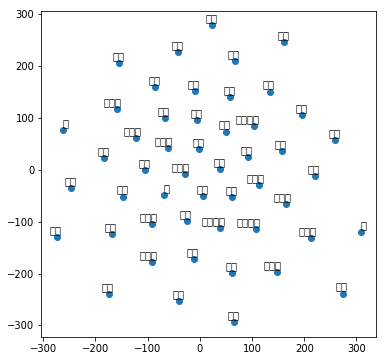

In [125]:
tsne_plot(model, None, 50)